<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blackjack

Example 5.1 and 5.3: from 'Reinforcement Learning: an introduction' by Sutton & Barto.

In [1]:
import gym
import itertools
import numpy as np

from tqdm.notebook import tqdm

from typing import Callable, Tuple

## Definitions

Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11. 
This game is placed with an infinite deck (or with replacement).

The game starts with dealer having one face up and one face down card, while
player having two face up cards.
The player can:
* request additional cards (hit=1) 
* until they decide to stop (stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater. If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21. The reward for:
* winning is +1,
* drawing is 0, 
* and losing is -1. 

The observation is a 3-tuple of:
* the players current sum,
* the dealer's one showing card (1-10 where 1 is ace),
* and whether or not the player holds a usable ace (0 or 1).

In [2]:
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.blackjack import draw_card

to_int = lambda obs: (obs[0], obs[1], int(obs[2]))

state_shape = lambda env: tuple(space.n for space in env.observation_space)
state_action_shape = lambda env: (*state_shape(env), env.action_space.n)

class BlackjackResettable(gym.envs.toy_text.blackjack.BlackjackEnv):
    def reset_to_state(self, player_cards, dealer_card):
        self.player = player_cards
        self.dealer = [dealer_card, draw_card(self.np_random)]
        return to_int(self._get_obs())

class ToIntObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, axis = 0): super().__init__(env)
    def observation(self, obs): return to_int(obs)

In [3]:
env = ToIntObsWrapper(BlackjackResettable(), axis = 2) # instead of: env = gym.make('Blackjack-v0')
# env?
spaces = [range(space.n) for space in env.observation_space]
states = list(itertools.product(spaces[0], spaces[1], spaces[2]))
print('Number of states =', len(states))

Number of states = 704


## Visualization

In [4]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
PLOT_INTERACTIVE = False

def plot_values(values, title):
    if PLOT_INTERACTIVE:
        fig = go.Figure(data=[go.Surface(z = values.T)])
        fig.update_layout(title = title,
                        width = 1200,
                        margin = { 'l': 10, 'r': 10, 'b': 10, 't': 35 },
                        scene = {
                            'xaxis': { 'range': [12, 21] },
                            'xaxis_title': 'sum',
                            'yaxis_title': 'Dealer\'s card',
                            'zaxis': { 'nticks': 3, 'range': [-1, 1] },
                            'zaxis_title': 'Reward',
                            'camera_eye': { 'x': -1, 'y': -1, 'z': 0.5},
                            'aspectratio': { 'x': 1, 'y': 1, 'z': 0.2}})
        fig.update_traces(showscale = False)
        fig.show()
    else:
        data = values[11:22, :]
        fig, ax = plt.subplots(figsize = (17, 7), subplot_kw = { 'projection': '3d' })
        X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
        surf = ax.plot_surface(X, Y, data, cmap = 'magma') #, vmin = -1, vmax = 1) 
        fig.colorbar(surf)
        ax.view_init(60, -60)
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_yticks(np.arange(data.shape[1]))
        ax.set_xticklabels(['A1', *(str(i) for i in range(2, 11)), 'A11'])
        ax.set_yticklabels(np.arange(11, 22))
        ax.set_xlabel('Dealer\'s card')
        ax.set_ylabel('Player\'s sum')
        ax.set_zlabel('Reward')
        ax.set_zlim(-1, 1)
        ax.set_title(title, pad = 50) 
        
def plot_policy(actions, title):
    if PLOT_INTERACTIVE:
        fig = go.Figure(data = go.Heatmap(z = actions))
        fig.update_layout(title = title, width = 1200)
        fig.update_xaxes(tickson = 'boundaries', 
                        tickmode = 'array',
                        tickvals = list(range(12)),
                        ticktext = ['A1', *(str(i) for i in range(2, 11)), 'A11'])
        fig.update_yaxes(tickson = 'boundaries', range = [11, 21], nticks = 12)
        fig.show()
    else:
        fig, ax = plt.subplots(figsize = (17, 7))
        data = actions[11:22, :]
        cmap = plt.cm.get_cmap('plasma', 2)
        heatmap = ax.pcolor(data, cmap = cmap)
        fig.colorbar(heatmap, ticks = [0, 1])
        ax.set_xticks(np.arange(data.shape[0]) + 0.5)
        ax.set_yticks(np.arange(data.shape[1]) + 0.5)
        ax.set_xticklabels(['A1', *(str(i) for i in range(2, 11)), 'A11'])
        ax.set_yticklabels(np.arange(11, 22))
        ax.set_xlabel('Dealer\'s card')
        ax.set_ylabel('Player\'s sum')
        ax.set_aspect('equal', adjustable = 'box')
        ax.set_title(title) 

## Monte Carlo Prediction

In [5]:
def _generate_episode(env, policy):
    st = env.reset()
    S, A, R = [], [], []
    while True:
        at = policy(st)
        st_1, rt_1, done, _ = env.step(at)
        S.append(st)
        A.append(at)
        R.append(rt_1)
        st = st_1
        if done: return S, A, R

def _update_returns(returns, s, G):
    avg, N = returns[s] if s in returns else (0.0, 0)
    returns[s] = (avg + (G - avg) / (N + 1), N + 1)
    return returns

def monte_carlo_prediction(env: gym.Env, policy: Callable[[Tuple[int, int, int]], int], 
                           gamma: float = 0.9, iters: int = 2000, 
                           first_visit: bool = True) -> np.ndarray:
    returns = {} # hosts mean return and occurences count for each state
    if first_visit:
        episode_returns = {} # host return for each state per episode
        for _ in tqdm(range(iters), total = iters):
            # simulate
            S, _, R = _generate_episode(env, policy)

            # replay backwards
            episode_returns.clear()
            G = 0
            for st, rt_1 in reversed(list(zip(S, R))):
                G = gamma * G + rt_1
                episode_returns[st] = G

            # update returns estimates with only the first visits
            for s, G in episode_returns.items():
                returns = _update_returns(returns, s, G)
    else:
        for _ in tqdm(range(iters), total = iters):
            # simulate
            S, _, R = _generate_episode(env, policy)
            
            # replay backwards
            G = 0
            for st, rt_1 in reversed(list(zip(S, R))):
                G = gamma * G + rt_1
                # update returns estimates for each visit
                returns = _update_returns(returns, st, G)

    # convert returns dict to np array
    V = np.zeros(state_shape(env)) # assumes all spaces are discrete
    for s, (avg, _) in returns.items(): V[s] = avg
    return V

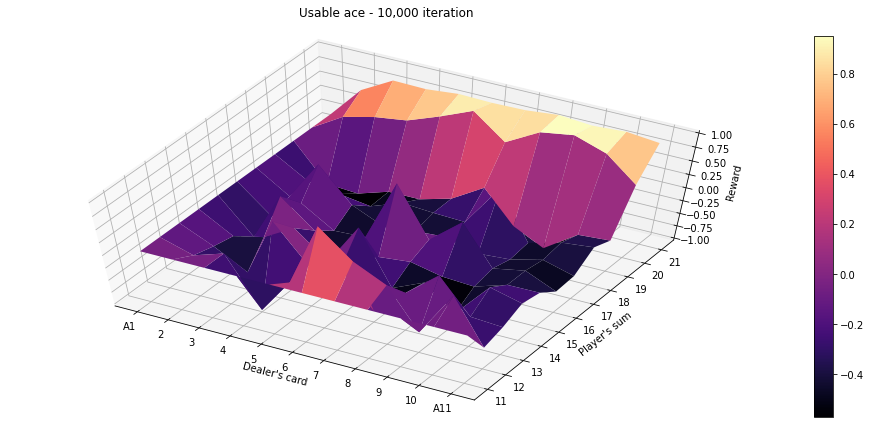

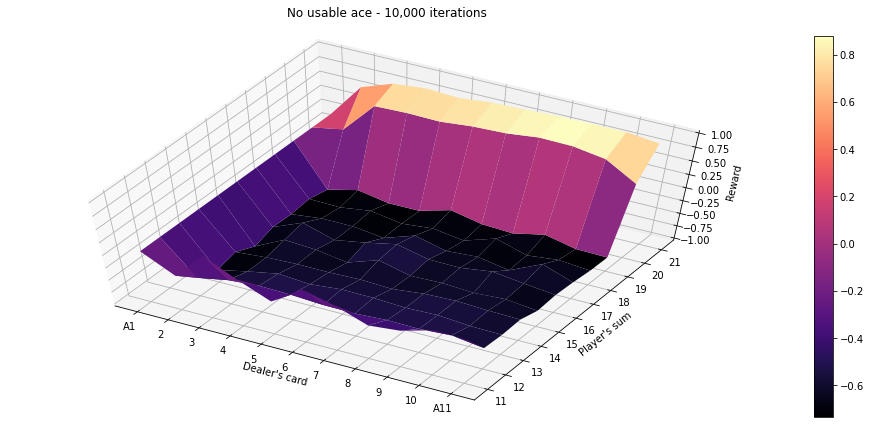

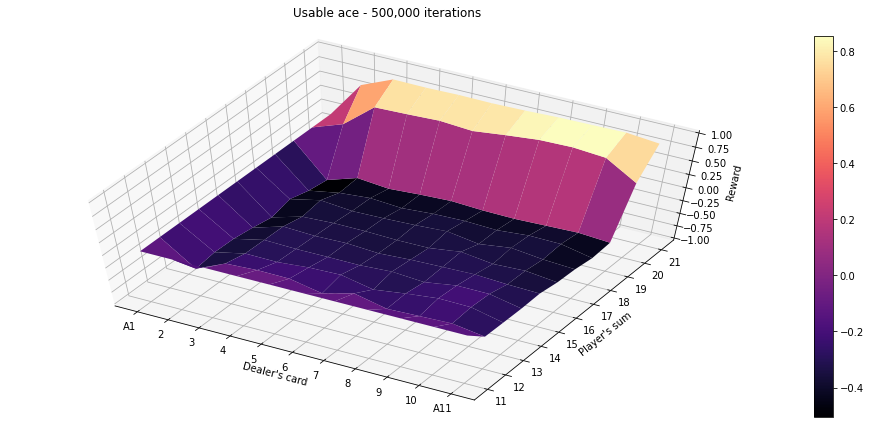

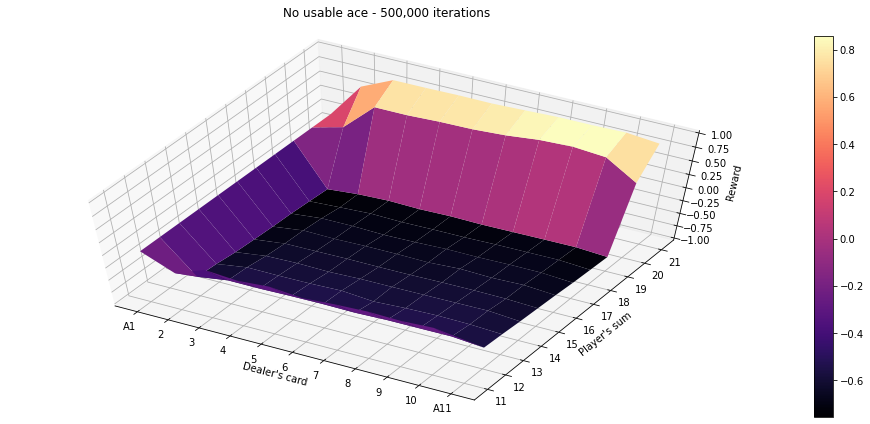

In [6]:
main_policy = lambda s: 0 if s[0] >= 20 else 1
random_policy = lambda s: np.random.randint(2)

state_values_1e4 = monte_carlo_prediction(env, main_policy, gamma = 1.0, iters = int(1e4))
state_values_5e5 = monte_carlo_prediction(env, main_policy, gamma = 1.0, iters = int(5e5))

plot_values(state_values_1e4[:, :, 1], 'Usable ace - 10,000 iteration')
plot_values(state_values_1e4[:, :, 0], 'No usable ace - 10,000 iterations')
plot_values(state_values_5e5[:, :, 1], 'Usable ace - 500,000 iterations')
plot_values(state_values_5e5[:, :, 0], 'No usable ace - 500,000 iterations')

## Monte Carlo with Exploring Starts

In [7]:
from gym.envs.toy_text.blackjack import draw_card
from gym.envs.toy_text.blackjack import draw_hand

def _generate_episode(env, policy):
    # not all states are generated with equal probabilities,
    # but this is a very simple fast to approximate a random state
    st = env.reset_to_state(draw_hand(env.np_random), draw_card(env.np_random))
    S, A, R = [], [], []
    while True:
        at = policy(st) if S else env.action_space.sample() # first action random
        st_1, rt_1, done, _ = env.step(at)
        S.append(st)
        A.append(at)
        R.append(rt_1)
        st = st_1
        if done: return S, A, R 

def monte_carlo_with_exploring_starts(env: gym.Env, gamma: float = 0.9, eps: float = 0.01, iters: int = 2000, first_visit: bool = False) -> np.ndarray:
    returns = {} # hosts mean return and occurences count for each state-pair
    Q = env.np_random.rand(*state_action_shape(env))
    policy = lambda s: Q[s].argmax()

    if first_visit:
        episode_returns = {} # host return for each state-pair per episode
        for _ in tqdm(range(iters), total = iters):
            # simulate
            S, A, R = _generate_episode(env, policy)

            # replay backwards
            episode_returns.clear()
            G = 0
            for st, at, rt_1 in reversed(list(zip(S, A, R))):
                G = gamma * G + rt_1
                episode_returns[(*st, at)] = G

            # update returns estimates with only the first visits
            for sa_pair, G in episode_returns.items():
                returns = _update_returns(returns, sa_pair, G)
                Q[sa_pair] = returns[sa_pair][0]
    else:
        for _ in tqdm(range(iters), total = iters):
            # simulate
            S, A, R = _generate_episode(env, policy, T)
            
            # replay backwards
            G = 0
            for st, at, rt_1 in reversed(list(zip(S, A, R))):
                G = gamma * G + rt_1
                # update returns estimates for each visit
                sa_pair = (*st, at)
                returns = _update_returns(returns, sa_pair, G)
                Q[sa_pair] = returns[sa_pair][0]
    return Q

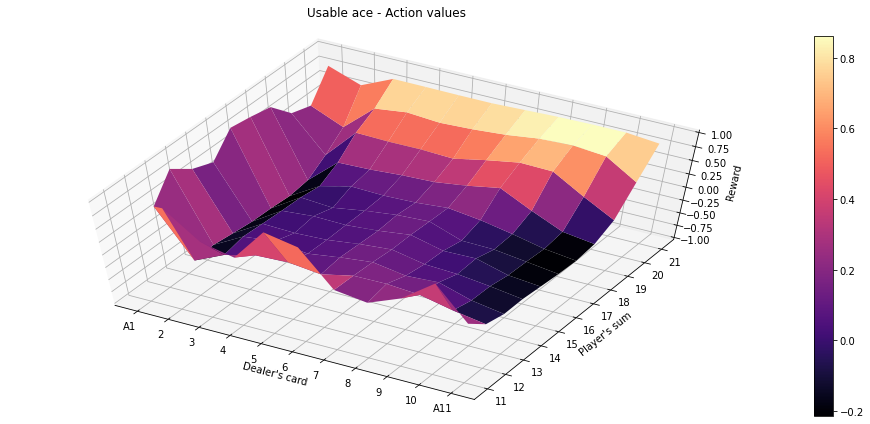

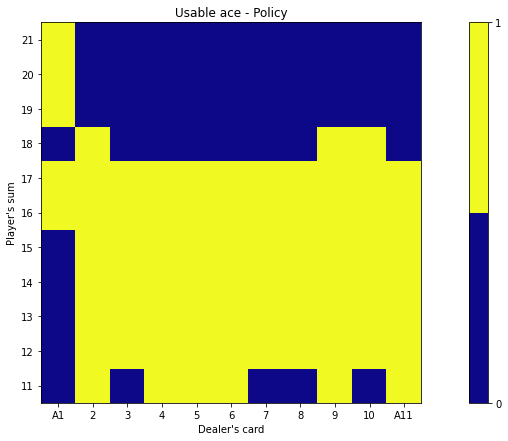

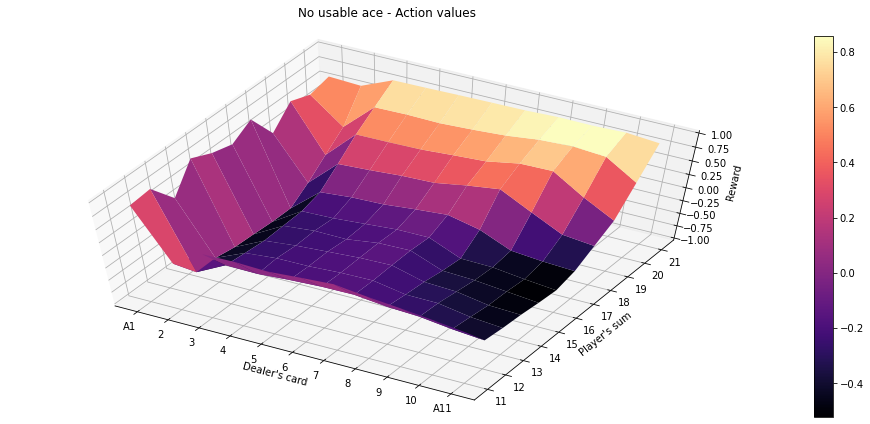

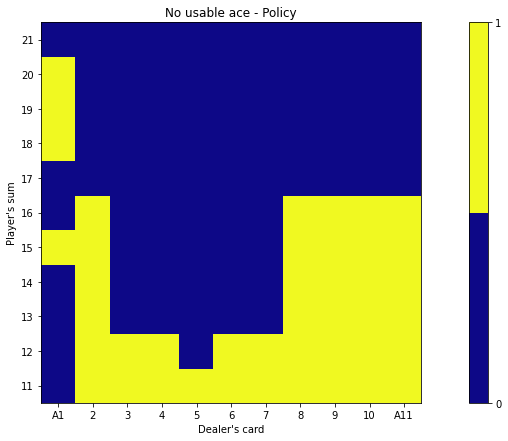

In [8]:
action_values = monte_carlo_with_exploring_starts(env, gamma = 1.0, iters = int(1e6), first_visit = True)

plot_values(action_values.max(axis = 3)[:, :, 1], 'Usable ace - Action values')
plot_policy(action_values.argmax(axis = 3)[:, :, 1], 'Usable ace - Policy')
plot_values(action_values.max(axis = 3)[:, :, 0], 'No usable ace - Action values')
plot_policy(action_values.argmax(axis = 3)[:, :, 0], 'No usable ace - Policy')